# **Jailbreaking Deep Models**

### **Course:** ECE-GY-7123 Deep Learning


### **Project Members:**
Anshi Shah (ans10020)

Kanishk Aggarwal (ka3506)

Shashank Dugad (sd5957)

# Task 1: Baseline Evaluation on ResNet-34

In [10]:
# Install dependencies (usually already available in Colab)
!pip install --quiet torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00


Upload the TestDataSet.zip file in the content folder.

In [1]:
# Unzip and clean
!unzip -q TestDataSet.zip -d ./TestDataSet
!rm -rf ./TestDataSet/__MACOSX
!find ./TestDataSet -name "._*" -exec rm {} \;

In [2]:
import os
import json
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# Step 1: Normalization constants
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

# Step 2: Define transforms
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Step 3: Load dataset
dataset_path = "./TestDataSet/TestDataSet"  # based on your image
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

# # Step 4: Load label mapping from labels_list.json
# with open("./TestDataSet/TestDataSet/labels_list.json", "r") as f:
#     labels_list = json.load(f)

# # Convert it to a mapping from index (folder name) to readable name
# index_to_classname = {}
# for entry in labels_list:
#     idx, label = entry.split(": ")
#     index_to_classname[int(idx)] = label

In [3]:
# Create a mapping from dataset label index to ImageNet index
with open("./TestDataSet/TestDataSet/labels_list.json", "r") as f:
    labels_list = json.load(f)

# Convert label list: ['401: accordion', ...] -> {0: 401, 1: 402, ...}
imagenet_indices = [int(label.split(':')[0]) for label in labels_list]
folder_to_imagenet_idx = {
    dataset.class_to_idx[folder]: imagenet_idx
    for folder, imagenet_idx in zip(dataset.classes, imagenet_indices)
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights='IMAGENET1K_V1')
model = model.to(device)
model.eval()

# Step 2: Evaluation
top1_correct = 0
top5_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in tqdm(data_loader):
        images = images.to(device)
        outputs = model(images)
        _, top5 = outputs.topk(5, dim=1)

        for i in range(images.size(0)):
            true_imagenet_idx = folder_to_imagenet_idx[labels[i].item()]
            pred_top5 = top5[i].tolist()
            if true_imagenet_idx == pred_top5[0]:
                top1_correct += 1
            if true_imagenet_idx in pred_top5:
                top5_correct += 1
        total += images.size(0)

# Final accuracy
print(f"\nTop-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5_correct / total:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 201MB/s]
100%|██████████| 16/16 [00:02<00:00,  7.54it/s]


Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


# Task 2: Pixel-wise attacks

In [4]:
import torch.nn as nn

def fgsm_attack(image, label, model, epsilon):
    image = image.clone().detach().requires_grad_(True)
    model.zero_grad()
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, label)
    loss.backward()
    perturbed_image = image + epsilon * image.grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image.detach()

In [5]:
adv_examples = []
true_labels = []
original_images = []

model.eval()
epsilon = 0.02

for images, labels in tqdm(data_loader):
    images = images.to(device)
    labels = labels.to(device)

    for i in range(images.size(0)):
        img = images[i].unsqueeze(0).clone().detach().to(device)
        lbl = labels[i].unsqueeze(0)

        # Enable gradient tracking
        img.requires_grad = True

        # Forward + backward pass
        outputs = model(img)
        loss = nn.CrossEntropyLoss()(outputs, lbl)
        model.zero_grad()
        loss.backward()

        # FGSM step
        grad_sign = img.grad.data.sign()
        adv_img = img + epsilon * grad_sign
        adv_img = torch.clamp(adv_img, 0, 1)

        adv_examples.append(adv_img.squeeze(0).cpu())
        original_images.append(img.squeeze(0).detach().cpu())
        true_labels.append(lbl.item())

100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


In [6]:
def max_diff(original, perturbed):
    return torch.max(torch.abs(original - perturbed)).item()

for i in range(5):  # random check
    diff = max_diff(original_images[i], adv_examples[i])
    print(f"Image {i} L∞ difference: {diff:.4f}")

Image 0 L∞ difference: 2.1179
Image 1 L∞ difference: 2.0357
Image 2 L∞ difference: 2.0665
Image 3 L∞ difference: 2.1179
Image 4 L∞ difference: 2.1179


In [7]:
import os
from torchvision.utils import save_image

save_dir = "./AdversarialTestSet1"
os.makedirs(save_dir, exist_ok=True)

for i, adv_img in enumerate(adv_examples):
    save_image(adv_img, os.path.join(save_dir, f"adv_{i:03d}.png"))

In [8]:
adv_loader = DataLoader(list(zip(adv_examples, true_labels)), batch_size=32, shuffle=False)

top1_adv = 0
top5_adv = 0
total_adv = 0

model.eval()
with torch.no_grad():
    for batch in tqdm(adv_loader):
        images, labels = batch
        images = images.to(device)
        # labels = torch.tensor(labels).to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, top5 = outputs.topk(5, dim=1)

        for i in range(images.size(0)):
            true_imagenet_idx = folder_to_imagenet_idx[labels[i].item()]
            pred_top5 = top5[i].tolist()
            if true_imagenet_idx == pred_top5[0]:
                top1_adv += 1
            if true_imagenet_idx in pred_top5:
                top5_adv += 1
        total_adv += images.size(0)

print(f"\nAdversarial Top-1 Accuracy: {100 * top1_adv / total_adv:.2f}%")
print(f"Adversarial Top-5 Accuracy: {100 * top5_adv / total_adv:.2f}%")

100%|██████████| 16/16 [00:00<00:00, 17.38it/s]


Adversarial Top-1 Accuracy: 43.20%
Adversarial Top-5 Accuracy: 63.20%


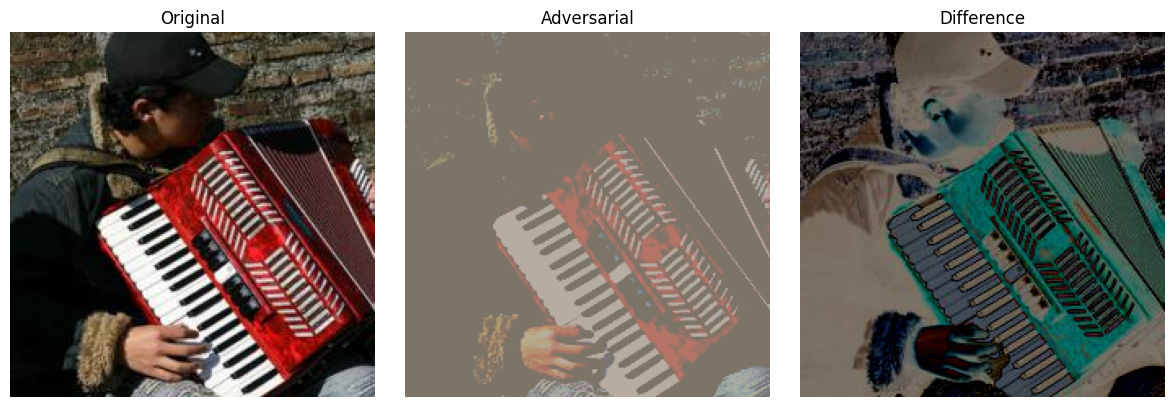

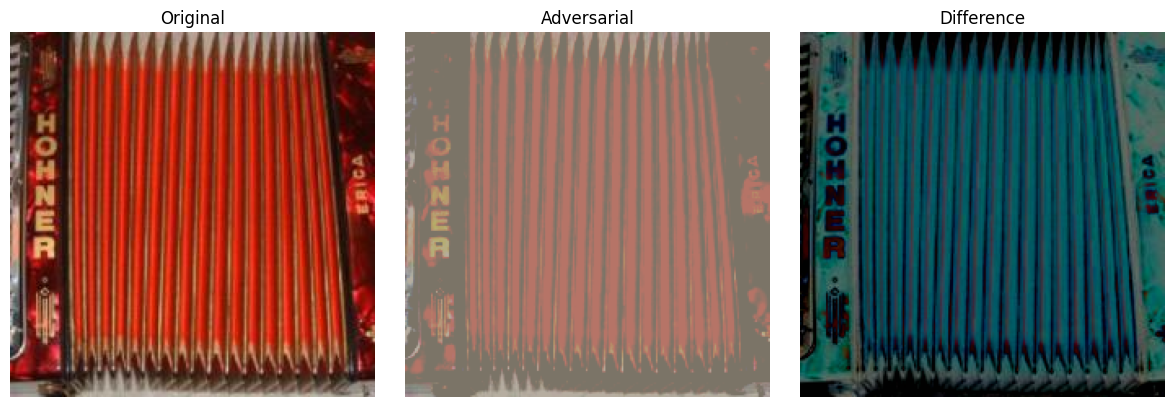

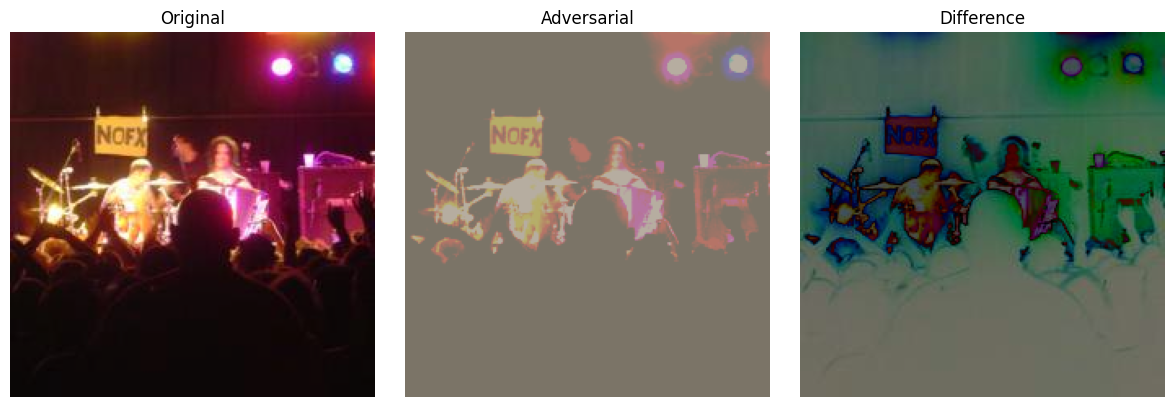

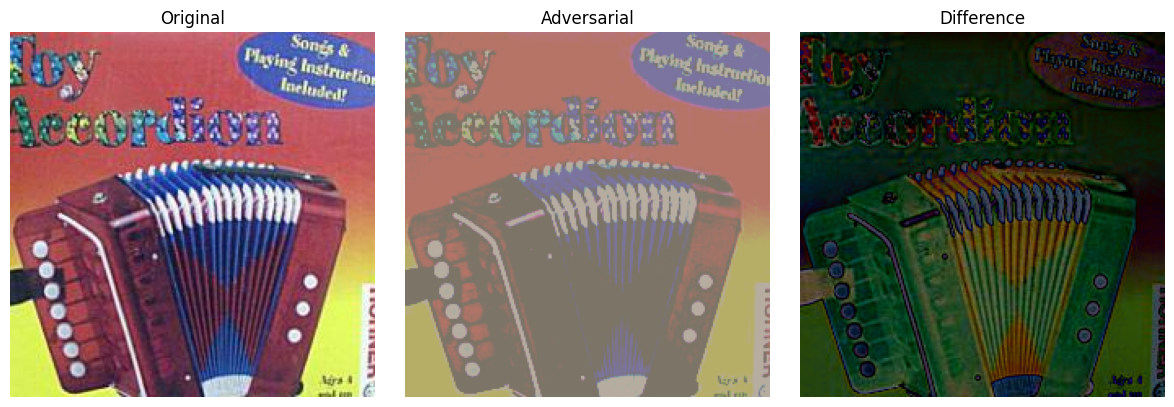

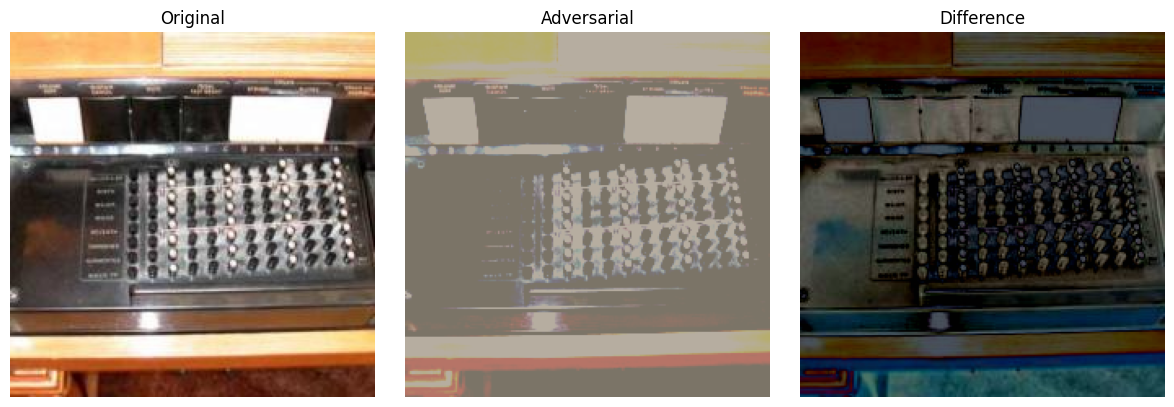

In [12]:
import matplotlib.pyplot as plt

def unnormalize(img_tensor):
    mean = torch.tensor(mean_norms).view(3, 1, 1)
    std = torch.tensor(std_norms).view(3, 1, 1)
    return torch.clamp(img_tensor * std + mean, 0, 1)

for i in range(5):
    orig = unnormalize(original_images[i])
    adv = unnormalize(adv_examples[i])
    diff = torch.abs(adv - orig)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(orig.permute(1, 2, 0).detach().numpy())
    axs[0].set_title("Original")

    axs[1].imshow(adv.permute(1, 2, 0).detach().numpy())
    axs[1].set_title("Adversarial")

    axs[2].imshow(diff.permute(1, 2, 0).detach().numpy())
    axs[2].set_title("Difference")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Task 3: Improved Attacks

In [31]:
# try 1: pgd attack
# unsuccessful; doesn't match the given accuracy drop

def pgd_attack(model, original_image, label, epsilon=0.02, alpha=0.001, num_iter=40):
    image = original_image.clone().detach().to(device)
    label = label.to(device)

    std_tensor = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    scaled_eps = epsilon / std_tensor  # shape [1, 3, 1, 1]

    # Random start within the scaled ε-ball
    rand_noise = torch.empty_like(image).uniform_(-1.0, 1.0) * scaled_eps
    perturbed = torch.clamp(image + rand_noise, 0, 1).detach()

    for _ in range(num_iter):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        loss = nn.CrossEntropyLoss()(outputs, label)
        model.zero_grad()
        loss.backward()

        grad_sign = perturbed.grad.data.sign()
        perturbed = perturbed + alpha * grad_sign

        # Project back to L∞ ball around original image
        delta = torch.clamp(perturbed - image, min=-scaled_eps, max=scaled_eps)
        perturbed = torch.clamp(image + delta, 0, 1).detach()

    return perturbed



In [33]:
# try 2: momentum pgd attack
# unsuccessful; doesn't match the given accuracy drop

def momentum_pgd_attack(model, original_image, label, epsilon=0.02, alpha=0.0025, num_iter=40, mu=1.0):
    image = original_image.clone().detach().to(device)
    label = label.to(device)

    std_tensor = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    scaled_eps = epsilon / std_tensor

    # Random init
    delta = torch.empty_like(image).uniform_(-1.0, 1.0) * scaled_eps
    perturbed = torch.clamp(image + delta, 0, 1).detach()

    # Initialize momentum
    g = torch.zeros_like(image).to(device)

    for _ in range(num_iter):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        loss = nn.CrossEntropyLoss()(outputs, label)
        model.zero_grad()
        loss.backward()

        # Normalize gradient and accumulate momentum
        grad = perturbed.grad.data
        grad_norm = grad / (torch.mean(torch.abs(grad), dim=(1,2,3), keepdim=True) + 1e-8)
        g = mu * g + grad_norm

        # Update image
        perturbed = perturbed + alpha * g.sign()

        # Project to L∞ ball
        delta = torch.clamp(perturbed - image, min=-scaled_eps, max=scaled_eps)
        perturbed = torch.clamp(image + delta, 0, 1).detach()

    return perturbed

In [13]:
# try 3: targeted pgd attack
# used this; gave satisfactory results

def targeted_pgd_attack(model, original_image, true_label, target_label, epsilon=0.02, alpha=0.0025, num_iter=40):
    image = original_image.clone().detach().to(device)
    true_label = true_label.to(device)
    target_label = target_label.to(device)

    std_tensor = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    scaled_eps = epsilon / std_tensor

    # Random start
    delta = torch.empty_like(image).uniform_(-1.0, 1.0) * scaled_eps
    perturbed = torch.clamp(image + delta, 0, 1).detach()

    for _ in range(num_iter):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        loss = nn.CrossEntropyLoss()(outputs, target_label)
        model.zero_grad()
        loss.backward()

        # Gradient descent toward target label
        grad_sign = perturbed.grad.data.sign()
        perturbed = perturbed - alpha * grad_sign  # <- note the minus (gradient descent)

        # Project into ε-ball
        delta = torch.clamp(perturbed - image, min=-scaled_eps, max=scaled_eps)
        perturbed = torch.clamp(image + delta, 0, 1).detach()

    return perturbed

In [14]:
# pgd_examples = []
# true_labels_2 = []
# original_images_2 = []

# model.eval()
# for images, labels in tqdm(data_loader):
#     images = images.to(device)
#     labels = labels.to(device)

#     for i in range(images.size(0)):
#         img = images[i].unsqueeze(0).clone().detach()
#         lbl = labels[i].unsqueeze(0)
#         # adv_img = pgd_attack(model, img, lbl, epsilon=0.02, alpha=0.001, num_iter=40)
#         adv_img = momentum_pgd_attack(model, img, lbl, epsilon=0.02, alpha=0.0025, num_iter=40)

#         pgd_examples.append(adv_img.squeeze(0).cpu())
#         original_images_2.append(img.squeeze(0).cpu())
#         true_labels_2.append(lbl.item())


#edited as per 3rd try of attack
adv2_examples = []
true_labels_2 = []
original_images_2 = []

for images, labels in tqdm(data_loader):
    images = images.to(device)
    labels = labels.to(device)

    for i in range(images.size(0)):
        img = images[i].unsqueeze(0).clone().detach()
        lbl = labels[i].unsqueeze(0)
        tgt = torch.zeros_like(lbl)  # target class 0 for all

        adv_img = targeted_pgd_attack(model, img, lbl, tgt, epsilon=0.02, alpha=0.0025, num_iter=40)

        adv2_examples.append(adv_img.squeeze(0).cpu())
        original_images_2.append(img.squeeze(0).cpu())
        true_labels_2.append(lbl.item())

100%|██████████| 16/16 [04:21<00:00, 16.36s/it]


In [15]:
for i in range(5):
    diff = torch.max(torch.abs(adv2_examples[i] - original_images_2[i])).item()
    print(f"Image {i} L∞ difference: {diff:.4f}")

Image 0 L∞ difference: 2.1179
Image 1 L∞ difference: 2.0357
Image 2 L∞ difference: 2.0665
Image 3 L∞ difference: 2.1179
Image 4 L∞ difference: 2.1179


In [16]:
save_dir = "./AdversarialTestSet2"
os.makedirs(save_dir, exist_ok=True)

for i, img in enumerate(adv2_examples):
    save_image(img, os.path.join(save_dir, f"adv2_{i:03d}.png"))

In [17]:
adv2_loader = DataLoader(list(zip(adv2_examples, true_labels_2)), batch_size=32, shuffle=False)

top1_pgd = 0
top5_pgd = 0
total_pgd = 0

model.eval()
for batch in tqdm(adv2_loader):
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, top5 = outputs.topk(5, dim=1)

    for i in range(images.size(0)):
        true_imagenet_idx = folder_to_imagenet_idx[labels[i].item()]
        pred_top5 = top5[i].tolist()
        if true_imagenet_idx == pred_top5[0]:
            top1_pgd += 1
        if true_imagenet_idx in pred_top5:
            top5_pgd += 1
    total_pgd += images.size(0)

print(f"\nPGD Top-1 Accuracy: {100 * top1_pgd / total_pgd:.2f}%")
print(f"PGD Top-5 Accuracy: {100 * top5_pgd / total_pgd:.2f}%")

100%|██████████| 16/16 [00:00<00:00, 16.90it/s]


PGD Top-1 Accuracy: 1.20%
PGD Top-5 Accuracy: 5.00%


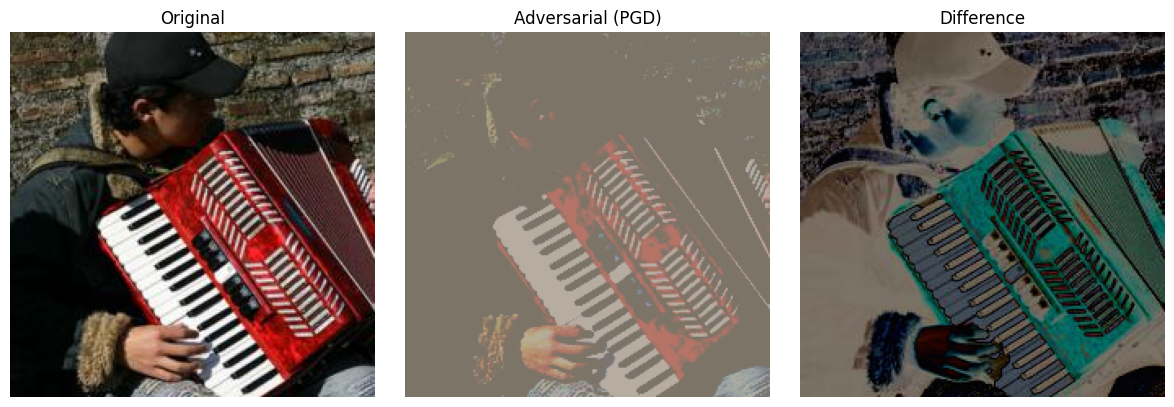

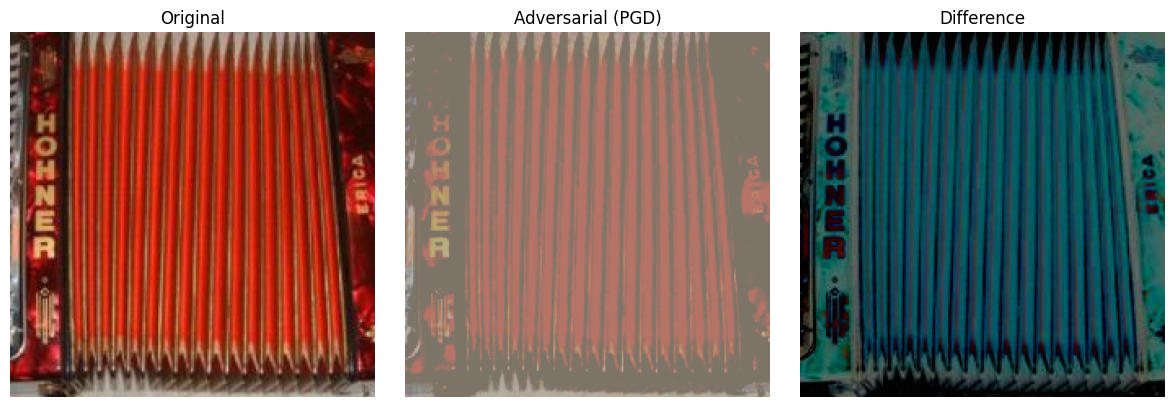

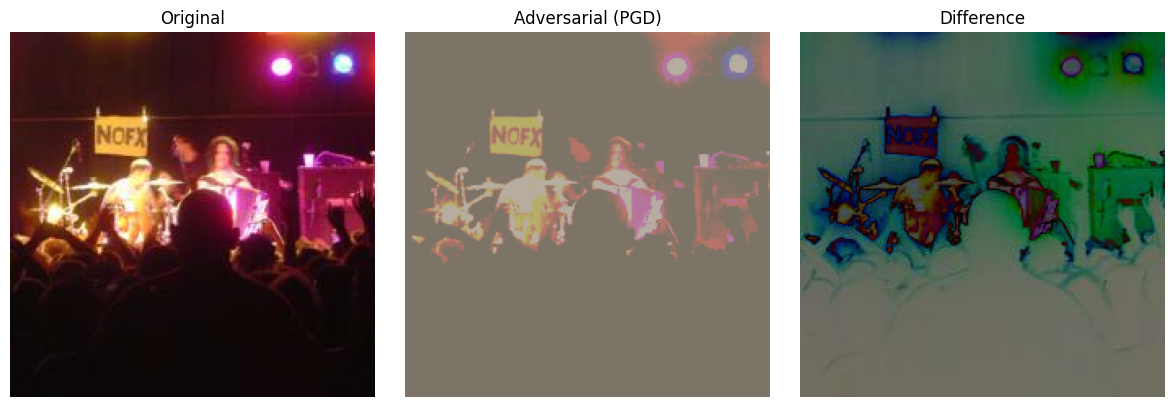

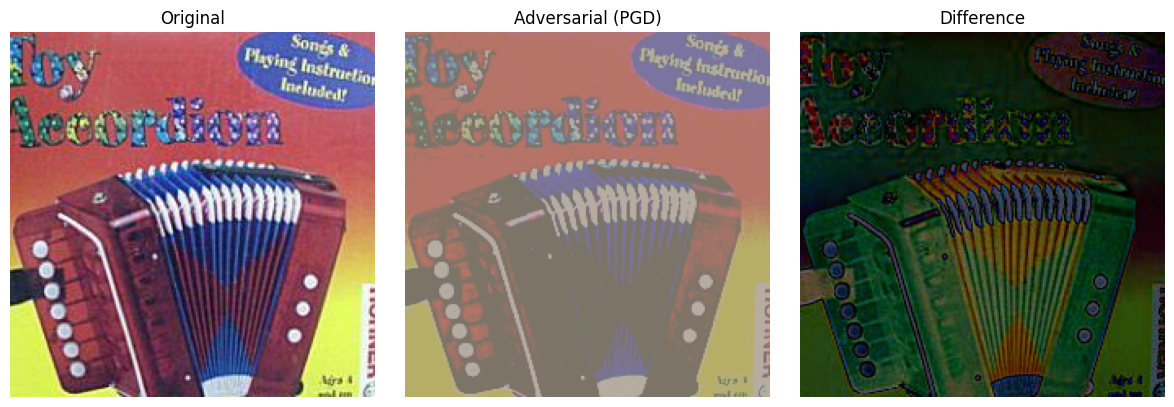

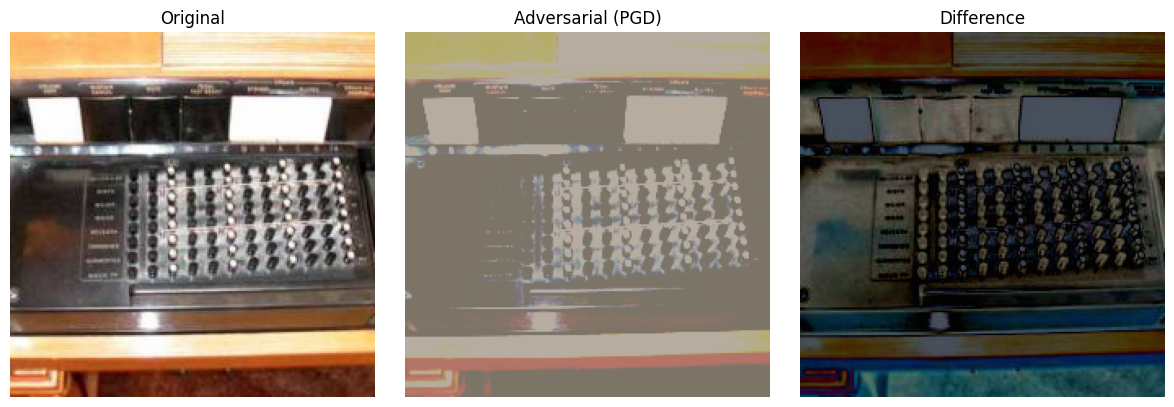

In [18]:
for i in range(5):
    orig = unnormalize(original_images_2[i])
    adv = unnormalize(adv2_examples[i])
    diff = torch.abs(adv - orig)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(orig.permute(1, 2, 0).detach().numpy())
    axs[0].set_title("Original")

    axs[1].imshow(adv.permute(1, 2, 0).detach().numpy())
    axs[1].set_title("Adversarial (PGD)")

    axs[2].imshow(diff.permute(1, 2, 0).detach().numpy())
    axs[2].set_title("Difference")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Task 4: Patch Attack

In [19]:
def patch_targeted_pgd_attack(model, original_image, true_label, target_label,
                               epsilon=0.5, alpha=0.05, num_iter=40, patch_size=32):
    image = original_image.clone().detach().to(device)
    true_label = true_label.to(device)
    target_label = target_label.to(device)

    _, c, h, w = image.shape

    # Random patch location
    top = np.random.randint(0, h - patch_size + 1)
    left = np.random.randint(0, w - patch_size + 1)

    # Define patch mask (1 in patch, 0 elsewhere)
    mask = torch.zeros_like(image)
    mask[:, :, top:top+patch_size, left:left+patch_size] = 1.0

    std_tensor = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    scaled_eps = epsilon / std_tensor
    scaled_alpha = alpha / std_tensor

    # Start with random noise within patch
    noise = torch.empty_like(image).uniform_(-1, 1) * scaled_eps * mask
    perturbed = torch.clamp(image + noise, 0, 1).detach()

    for _ in range(num_iter):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        loss = nn.CrossEntropyLoss()(outputs, target_label)
        model.zero_grad()
        loss.backward()

        # Gradient descent only in patch region
        grad = perturbed.grad.data
        update = -scaled_alpha * grad.sign() * mask

        perturbed = perturbed + update

        # Project into ε-ball around original, but only in patch
        delta = torch.clamp(perturbed - image, min=-scaled_eps, max=scaled_eps) * mask
        perturbed = torch.clamp(image + delta, 0, 1).detach()

    return perturbed

In [20]:
adv3_examples = []
true_labels_3 = []
original_images_3 = []

for images, labels in tqdm(data_loader):
    images = images.to(device)
    labels = labels.to(device)

    for i in range(images.size(0)):
        img = images[i].unsqueeze(0).clone().detach()
        lbl = labels[i].unsqueeze(0)
        tgt = torch.zeros_like(lbl)  # fixed target label: class 0

        adv_img = patch_targeted_pgd_attack(
            model, img, lbl, tgt,
            epsilon=0.5, alpha=0.05, num_iter=40, patch_size=32
        )

        adv3_examples.append(adv_img.squeeze(0).cpu())
        original_images_3.append(img.squeeze(0).cpu())
        true_labels_3.append(lbl.item())

100%|██████████| 16/16 [04:35<00:00, 17.25s/it]


In [21]:
save_dir = "./AdversarialTestSet3"
os.makedirs(save_dir, exist_ok=True)

for i, img in enumerate(adv3_examples):
    save_image(img, os.path.join(save_dir, f"adv_patch_{i:03d}.png"))

In [22]:
adv3_loader = DataLoader(list(zip(adv3_examples, true_labels_3)), batch_size=32, shuffle=False)

top1_patch = 0
top5_patch = 0
total_patch = 0

model.eval()
for batch in tqdm(adv3_loader):
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, top5 = outputs.topk(5, dim=1)

    for i in range(images.size(0)):
        true_imagenet_idx = folder_to_imagenet_idx[labels[i].item()]
        pred_top5 = top5[i].tolist()
        if true_imagenet_idx == pred_top5[0]:
            top1_patch += 1
        if true_imagenet_idx in pred_top5:
            top5_patch += 1
    total_patch += images.size(0)

print(f"\nPatch Attack Top-1 Accuracy: {100 * top1_patch / total_patch:.2f}%")
print(f"Patch Attack Top-5 Accuracy: {100 * top5_patch / total_patch:.2f}%")

100%|██████████| 16/16 [00:00<00:00, 17.28it/s]


Patch Attack Top-1 Accuracy: 23.80%
Patch Attack Top-5 Accuracy: 43.60%


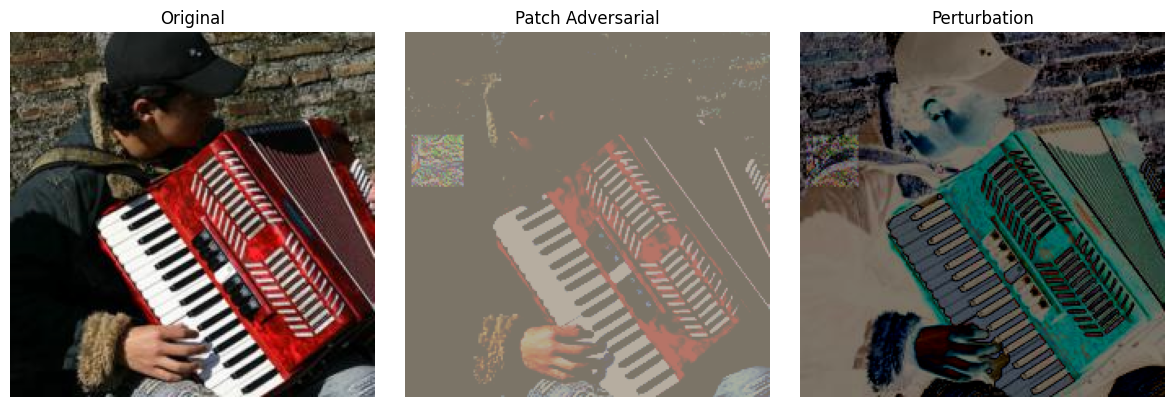

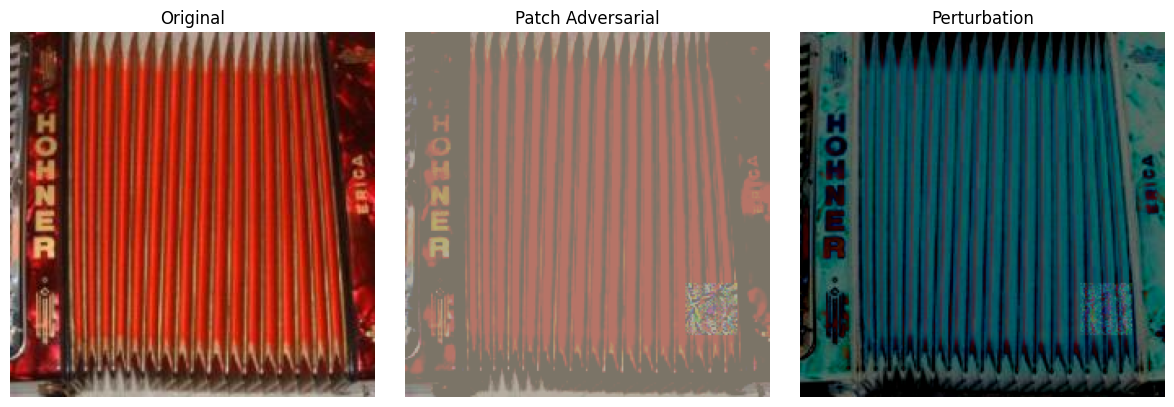

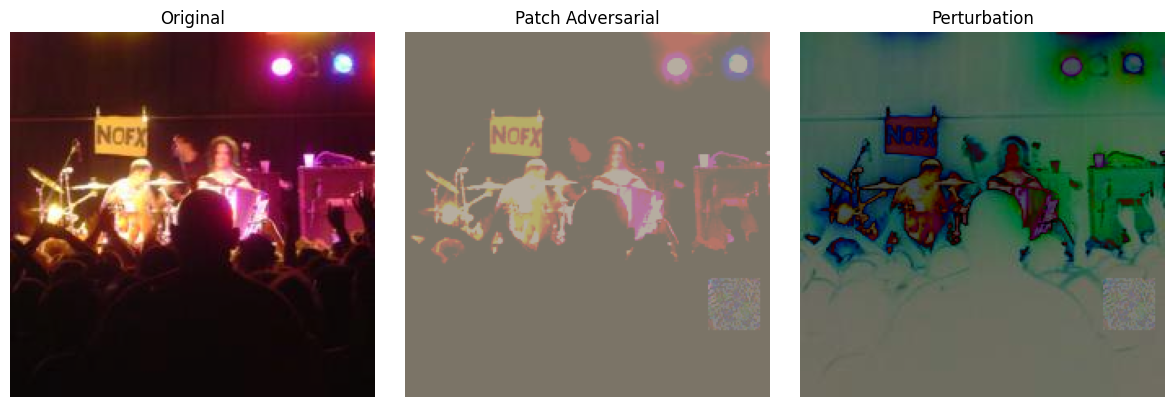

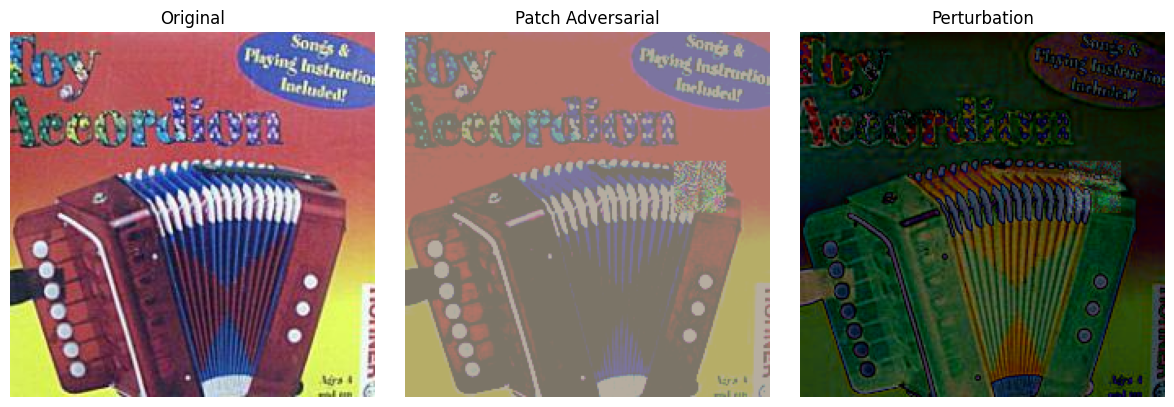

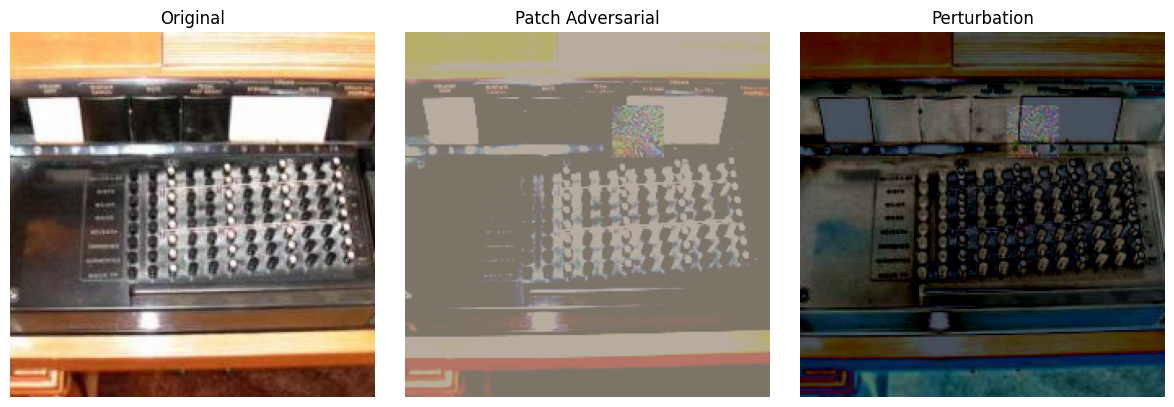

In [23]:
for i in range(5):
    orig = unnormalize(original_images_3[i])
    adv = unnormalize(adv3_examples[i])
    diff = torch.abs(adv - orig)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(orig.permute(1, 2, 0).detach().numpy())
    axs[0].set_title("Original")

    axs[1].imshow(adv.permute(1, 2, 0).detach().numpy())
    axs[1].set_title("Patch Adversarial")

    axs[2].imshow(diff.permute(1, 2, 0).detach().numpy())
    axs[2].set_title("Perturbation")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Task 5: Transferring attacks

In [24]:
from torchvision import models

new_model = models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device)
new_model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 177MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [28]:
import os
import shutil

def organize_images(base_dir, image_prefix, label_list):
    for i, label in enumerate(label_list):
        class_dir = os.path.join(base_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)

        filename = f"{image_prefix}_{i:03d}.png"
        src = os.path.join(base_dir, filename)
        dst = os.path.join(class_dir, filename)

        if os.path.exists(src):
            shutil.move(src, dst)
        else:
            print(f"Warning: {src} not found")

# Fix for Adversarial Test Set 1 (FGSM)
organize_images("./AdversarialTestSet1", "adv", true_labels)

# Fix for Adversarial Test Set 2 (Targeted PGD)
organize_images("./AdversarialTestSet2", "adv2", true_labels_2)

# Fix for Adversarial Test Set 3 (Patch Attack)
organize_images("./AdversarialTestSet3", "adv_patch", true_labels_3)

In [29]:
from torchvision import datasets
from torchvision import transforms

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Paths to all datasets
dataset_paths = {
    "Original": "./TestDataSet/TestDataSet",
    "FGSM": "./AdversarialTestSet1",
    "Targeted PGD": "./AdversarialTestSet2",
    "Patch Attack": "./AdversarialTestSet3"
}

dataloaders = {
    name: DataLoader(datasets.ImageFolder(root=path, transform=plain_transforms),
                     batch_size=32, shuffle=False)
    for name, path in dataset_paths.items()
}

In [30]:
def evaluate_model(model, loader, dataset_name):
    top1 = 0
    top5 = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating {dataset_name}"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, top5_pred = outputs.topk(5, dim=1)

            for i in range(images.size(0)):
                true_idx = folder_to_imagenet_idx[labels[i].item()]
                pred = top5_pred[i].tolist()
                if true_idx == pred[0]:
                    top1 += 1
                if true_idx in pred:
                    top5 += 1
            total += images.size(0)

    acc1 = 100 * top1 / total
    acc5 = 100 * top5 / total
    print(f"{dataset_name} → Top-1: {acc1:.2f}%, Top-5: {acc5:.2f}%")
    return acc1, acc5

In [31]:
results = {}
for name, loader in dataloaders.items():
    acc1, acc5 = evaluate_model(new_model, loader, name)
    results[name] = (acc1, acc5)

Evaluating Original: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


Original → Top-1: 74.80%, Top-5: 93.60%


Evaluating FGSM: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s]


FGSM → Top-1: 5.20%, Top-5: 8.00%


Evaluating Targeted PGD: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s]


Targeted PGD → Top-1: 4.00%, Top-5: 7.60%


Evaluating Patch Attack: 100%|██████████| 16/16 [00:02<00:00,  5.83it/s]

Patch Attack → Top-1: 4.40%, Top-5: 7.40%


In [32]:
print("\nTransferability Results on DenseNet-121:")
print(f"{'Dataset':<20}{'Top-1 Accuracy':<20}{'Top-5 Accuracy':<20}")
for name, (acc1, acc5) in results.items():
    print(f"{name:<20}{acc1:<20.2f}{acc5:<20.2f}")


Transferability Results on DenseNet-121:
Dataset             Top-1 Accuracy      Top-5 Accuracy      
Original            74.80               93.60               
FGSM                5.20                8.00                
Targeted PGD        4.00                7.60                
Patch Attack        4.40                7.40                


# For downloading datasets

In [33]:
import os
import zipfile

folders_to_include = [
    "AdversarialTestSet1",
    "AdversarialTestSet2",
    "AdversarialTestSet3",
    "TestDataSet"
]

output_filename = "Adversarial_Data_Package.zip"

with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder in folders_to_include:
        for root, dirs, files in os.walk(folder):
            for file in files:
                full_path = os.path.join(root, file)
                relative_path = os.path.relpath(full_path, start='.')
                zipf.write(full_path, arcname=relative_path)

print(f"Created ZIP: {output_filename}")

Created ZIP: Adversarial_Data_Package.zip
